# Real-World Applications of Boolean Function Analysis

This notebook demonstrates practical applications of Boolean function analysis using `boofun`.

## Contents
1. **Voting Systems Analysis** - Analyzing power distribution in weighted voting
2. **Cryptographic S-Box Analysis** - Measuring nonlinearity and security properties
3. **Feature Selection** - Using influence to identify important features
4. **Error-Correcting Codes** - Analyzing code properties via Fourier

In [1]:
# Install/upgrade boofun (required for Colab)
# This ensures you have the latest version with all features
!pip install --upgrade boofun -q

import boofun as bf
print(f"BooFun version: {bf.__version__}")


[notice] A new release of pip is available: 25.2 -> 26.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


/Users/gabrieltaboada/dev/Boofun/boofun/src/boofun/core/errormodels.py:21: UserWarning: uncertainties library not available - some error models disabled
  warnings.warn("uncertainties library not available - some error models disabled")


/Users/gabrieltaboada/dev/Boofun/boofun/src/boofun/quantum/__init__.py:22: UserWarning: Qiskit not available - quantum features limited
  warnings.warn("Qiskit not available - quantum features limited")


BooFun version: 1.1.1


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import boofun as bf

np.random.seed(42)
plt.rcParams['figure.figsize'] = (12, 5)
print("✓ boofun loaded")

✓ boofun loaded


## 1. Voting Systems Analysis

Weighted voting systems can be modeled as **Linear Threshold Functions (LTFs)**. 
The **Banzhaf power index** equals the **influence** of each voter!

### Example: U.S. Electoral College (simplified)

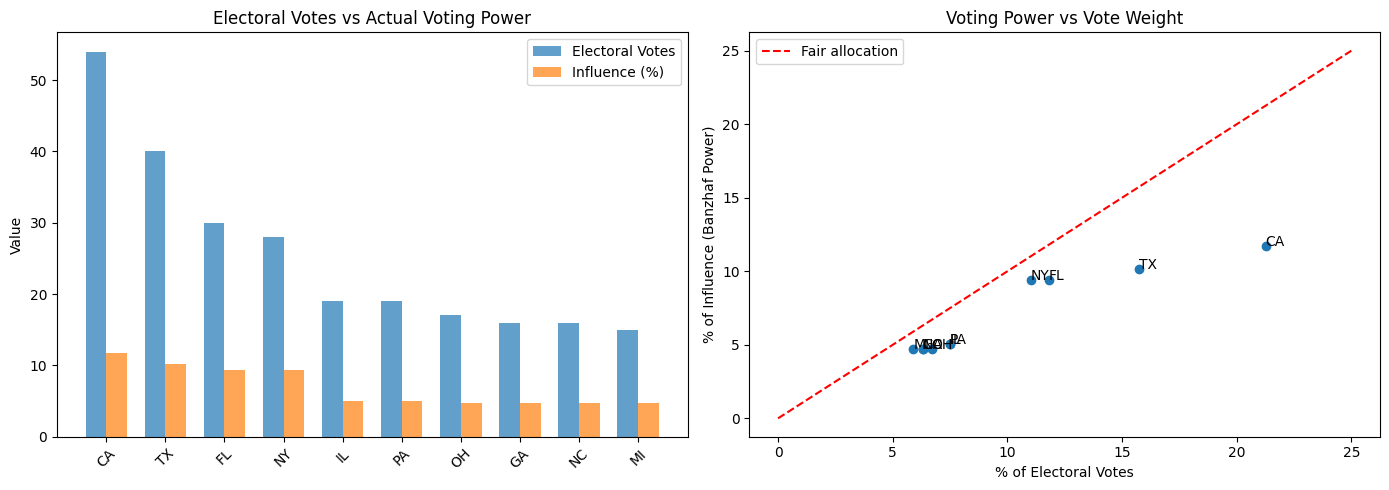

💡 Key insight: Influence doesn't scale linearly with electoral votes!


In [3]:
# Simplified Electoral College: Top 10 states by electoral votes (2024)
states = ["CA", "TX", "FL", "NY", "IL", "PA", "OH", "GA", "NC", "MI"]
electoral_votes = [54, 40, 30, 28, 19, 19, 17, 16, 16, 15]

# Create weighted voting function (need 270 to win = 139 from these 10)
n = len(states)
electoral = bf.from_weights(electoral_votes, threshold_value=139)

# Compute influence (= Banzhaf power)
influences = electoral.influences()

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Electoral votes vs Influence
ax1 = axes[0]
x = np.arange(n)
width = 0.35
ax1.bar(x - width/2, electoral_votes, width, label='Electoral Votes', alpha=0.7)
ax1.bar(x + width/2, influences * 100, width, label='Influence (%)', alpha=0.7)
ax1.set_xticks(x)
ax1.set_xticklabels(states, rotation=45)
ax1.set_ylabel('Value')
ax1.set_title('Electoral Votes vs Actual Voting Power')
ax1.legend()

# Power imbalance
ax2 = axes[1]
normalized_ev = np.array(electoral_votes) / sum(electoral_votes) * 100
ax2.scatter(normalized_ev, influences * 100)
for i, state in enumerate(states):
    ax2.annotate(state, (normalized_ev[i], influences[i] * 100))
ax2.plot([0, 25], [0, 25], 'r--', label='Fair allocation')
ax2.set_xlabel('% of Electoral Votes')
ax2.set_ylabel('% of Influence (Banzhaf Power)')
ax2.set_title('Voting Power vs Vote Weight')
ax2.legend()

plt.tight_layout()
plt.show()

print("💡 Key insight: Influence doesn't scale linearly with electoral votes!")

## 2. Cryptographic S-Box Analysis

S-boxes are lookup tables used in block ciphers (AES, DES). Their **nonlinearity** - distance from any linear function - is critical for security.

**High nonlinearity** → Resistant to linear cryptanalysis

S-Box Component Analysis (bent function 0xac90):
  Variables: 4
  Is balanced: False
  Is linear: False
  Nonlinearity: 6 (max for n=4: 6)
  Is bent: True


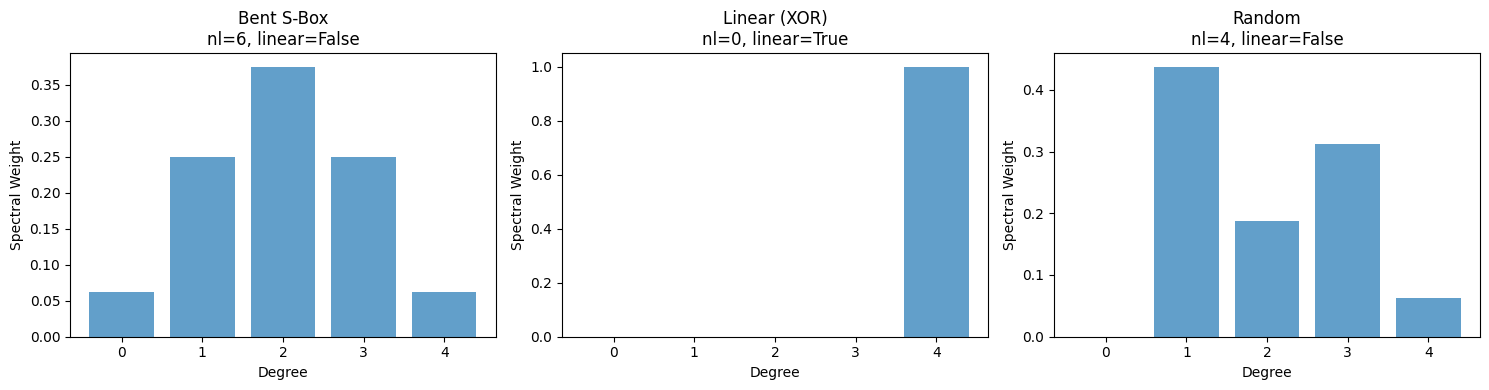

Good S-boxes spread weight across multiple degrees (confusion).


In [ ]:
# Create a 4-bit S-box component (bent function - maximum nonlinearity)
from boofun.analysis.cryptographic import nonlinearity as compute_nonlinearity

sbox = bf.from_hex("ac90", n=4)  # Known 4-variable bent function

# Analyze cryptographic properties
n = sbox.n_vars
max_nl = 2**(n - 1) - 2**(n // 2 - 1)  # Bent bound for even n
nl = compute_nonlinearity(sbox)

print("S-Box Component Analysis (bent function 0xac90):")
print(f"  Variables: {n}")
print(f"  Is balanced: {sbox.is_balanced()}")
print(f"  Is linear: {sbox.is_linear()}")
print(f"  Nonlinearity: {nl} (max for n={n}: {max_nl})")
print(f"  Is bent: {nl == max_nl}")

# Compare with linear and random functions
linear = bf.parity(4)  # Linear (worst case for crypto)
random_f = bf.random(4, balanced=True)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (name, f) in zip(axes, [("Bent S-Box", sbox), ("Linear (XOR)", linear), ("Random", random_f)]):
    weights = f.spectral_weight_by_degree()
    f_nl = compute_nonlinearity(f)
    ax.bar(weights.keys(), weights.values(), alpha=0.7)
    ax.set_title(f"{name}\nnl={f_nl}, linear={f.is_linear()}")
    ax.set_xlabel("Degree")
    ax.set_ylabel("Spectral Weight")

plt.tight_layout()
plt.show()

print("Good S-boxes spread weight across multiple degrees (confusion).")

## 3. Feature Selection via Influence

In machine learning, **variable influence** identifies which features matter most for a Boolean classifier.

High influence → Feature significantly affects the output

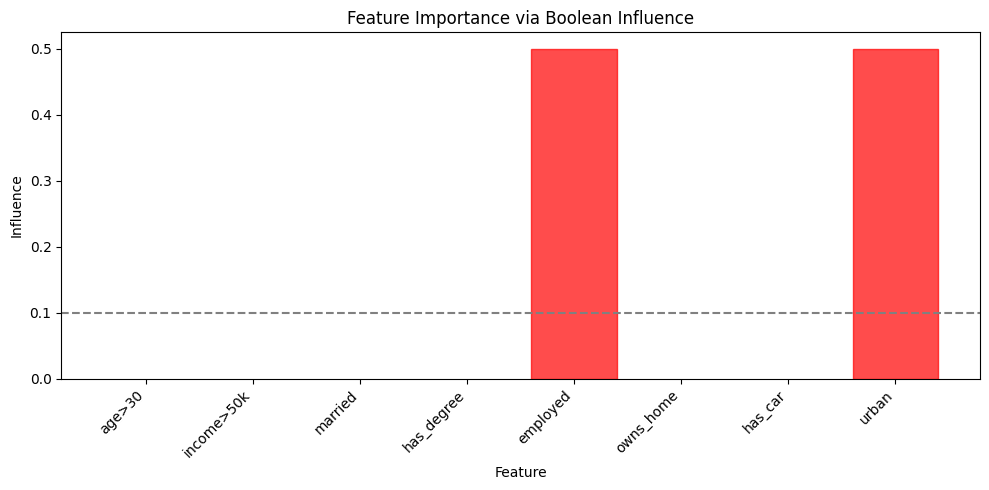

💡 Important features (influence > 0.1): ['employed', 'urban']
   The classifier is a 2-junta!


In [5]:
# Simulate a "learned" classifier that's secretly a 2-junta
# (only depends on 2 of 8 features)
n_features = 8
feature_names = ["age>30", "income>50k", "married", "has_degree", 
                 "employed", "owns_home", "has_car", "urban"]

# Create hidden 2-junta: output = (feature_0 AND feature_3)
# Most features are irrelevant!
truth_table = []
for x in range(2**n_features):
    bit0 = (x >> 7) & 1  # Feature 0
    bit3 = (x >> 4) & 1  # Feature 3
    truth_table.append(bit0 & bit3)

classifier = bf.create(truth_table)

# Use influence to find important features
influences = classifier.influences()

plt.figure(figsize=(10, 5))
bars = plt.bar(feature_names, influences, alpha=0.7)
# Highlight important features
for i, inf in enumerate(influences):
    if inf > 0.1:
        bars[i].set_color('red')
plt.xlabel("Feature")
plt.ylabel("Influence")
plt.title("Feature Importance via Boolean Influence")
plt.xticks(rotation=45, ha='right')
plt.axhline(y=0.1, color='gray', linestyle='--', label='Threshold')
plt.tight_layout()
plt.show()

# Report findings
important = [feature_names[i] for i, inf in enumerate(influences) if inf > 0.1]
print(f"💡 Important features (influence > 0.1): {important}")
print(f"   The classifier is a {len(important)}-junta!")

## Summary

| Application | Boolean Concept | boofun Method |
|-------------|-----------------|-----------------|
| Voting power | Influence | `f.influences()` |
| Crypto security | Nonlinearity | `f.fourier()`, `f.is_linear()` |
| Feature selection | Junta detection | `f.influences()`, `f.is_junta(k)` |
| Code analysis | Weight distribution | `f.hamming_weight()`, `f.spectral_weight_by_degree()` |

### Key boofun Functions Used
```python
# Create functions
bf.from_weights(weights)     # Weighted voting (LTF)
bf.random(n, balanced=True)  # Random function
bf.create(truth_table)       # From explicit truth table

# Analyze
f.influences()               # Variable importance
f.is_linear()                # Linearity test
f.is_junta(k)                # k-junta test
f.fourier()                  # Fourier coefficients
f.spectral_weight_by_degree() # Weight distribution
```